In [1]:
import pandas as pd

import xarray as xr
import zarr
import gcsfs

import numpy as np

from dask.distributed import Client

import cartopy.crs as ccrs
import cartopy.feature as cf

import seaborn as sns
import matplotlib.pyplot as plt

plt.rc('figure', dpi=100)


GCP_PROJECT_ID = '170771369993'
OISST_GCP = 'oisst/oisst.zarr'

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:39513 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 33.45 GB


In [3]:
client.cluster.scale(16)

# How close is SST to $T_\mathrm{opt}$ for Phytoplankton Species at Isolation Site?
data from [Thomas et al. 2012](http://www.researchgate.net/profile/Mridul_Thomas/publication/232742044_A_Global_Pattern_of_Thermal_Adaptation_in_Marine_Phytoplankton/links/0912f51261c0eee20b000000.pdf)

In [4]:
plankton = pd.read_csv("../../data/Phytoplankton_temperature_growth_rate_dataset_2016_01_29/traits_derived_2016_01_29.csv", engine='python')

In [5]:
plankton = plankton[
    (plankton.habitat == 'marine') &
    (plankton.curvequal == 'good')
]
plankton = plankton.dropna(subset=['isolation.latitude', 'isolation.longitude'])

len(plankton)

89

In [6]:
## load SST
fs = gcsfs.GCSFileSystem(project=GCP_PROJECT_ID, token="../../gc-pangeo.json")
oisst = xr.open_zarr(fs.get_mapper(OISST_GCP))
oisst = oisst.assign_coords(lon=(((oisst.lon + 180) % 360) - 180)).sortby('lon')

## 1)  Count $T_\mathrm{opt}$ exceedances.

We compute the number of days in SST record (1981-2020) where $\textsf{SST} \gt T_\mathrm{opt} \forall $ species at their isolation site. 

In [7]:
topt_colname = 'mu.g.opt.list' ## 29) mu.g.opt.list = estimated optimum temperature for growth 

In [94]:
exceedance_count = []
for _i, species in plankton.iterrows():
    lat = species['isolation.latitude']
    lon = species['isolation.longitude']
    
    _sst = oisst.sel(lat = lat, lon = lon, method='nearest', tolerance = 0.5) # SST within 0.5 deg

    exceedance_count.append((_sst.sst > species[topt_colname]).astype('int').sum())


In [9]:
answer = client.compute(exceedance_count, sync=True, optimize_graph=True)

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:52878 remote=tcp://127.0.0.1:39513>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:52882 remote=tcp://127.0.0.1:39513>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:52884 remote=tcp://127.0.0.1:39513>


In [10]:
plankton['topt_exceedances'] = list(map(np.asscalar, answer))

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  """Entry point for launching an IPython kernel.


In [11]:
plankton['topt_exceedances_pct'] = plankton.topt_exceedances / len(oisst.time)

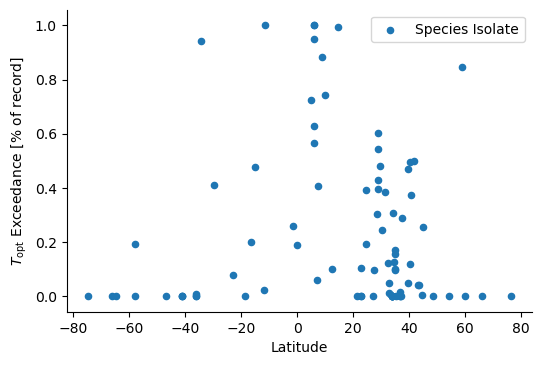

In [98]:
plankton.plot(x = 'isolation.latitude', y='topt_exceedances_pct', kind='scatter', label='Species Isolate')
sns.despine()
plt.xlabel("Latitude")
plt.ylabel("$T_\mathrm{opt}$ Exceedance [% of record]")
plt.legend()

## 2) Examine one Example (by # exceedances)


In [102]:
high_example = plankton.sort_values('topt_exceedances', ascending=False).iloc[2]
print(high_example)

isolate.code                                                          45
source                                                               NaN
isolation.latitude                                                -11.54
isolation.longitude                                               -28.58
habitat                                                           marine
name                                 Pernambugia tuberosa strain GeoB*74
speciesname                                         Pernambugia tuberosa
former.name.1                                                        NaN
former.name.2                                                        NaN
strain                                                           GeoB*74
clone                                                                NaN
species                                                         tuberosa
genus                                                        Pernambugia
family                                             

In [105]:
_sst = oisst.sel(lat=high_example['isolation.latitude'], lon=high_example['isolation.longitude'], method='nearest', tolerance=0.5)


Text(0, 0.5, '# Days')

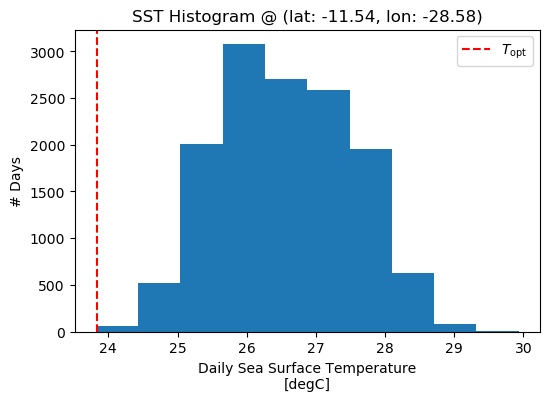

In [109]:
_sst.sst.plot.hist()
plt.axvline(high_example[topt_colname], color='red', linestyle='--', label='$T_\mathrm{opt}$')
plt.legend()
plt.title(f"SST Histogram @ (lat: {high_example['isolation.latitude']}, lon: {high_example['isolation.longitude']})")
plt.ylabel("# Days")

## 4) Seasonal Percentages

We compute the percentage of all SST observations greater than $T_\mathrm{opt}$ for each season for each species

In [15]:
seasonal_exceedance_count = []
for _i, species in plankton.iterrows():
    lat = species['isolation.latitude']
    lon = species['isolation.longitude']
    
    _sst = oisst.sel(lat = lat, lon = lon, method='nearest', tolerance = 0.5) # SST within 0.5 deg
    
    seasonal_exceedance_percentages= (_sst.sst > species[topt_colname]).astype('int').groupby(_sst.time.dt.season).apply(lambda x: x.sum() / len(x))
    
    
    seasonal_exceedance_count.append(seasonal_exceedance_percentages)

In [16]:
_seas_ex = client.compute(seasonal_exceedance_count, sync=True)

In [74]:
seas_ex_df = pd.concat(
    [_data.to_dataframe().drop(['lat', 'lon'], axis=1).T.reset_index().drop('index', axis=1).rename({0: i}, axis=0).add_prefix("exceedance_pct_") 
     for i, _data in zip(plankton.index, _seas_ex)]
)


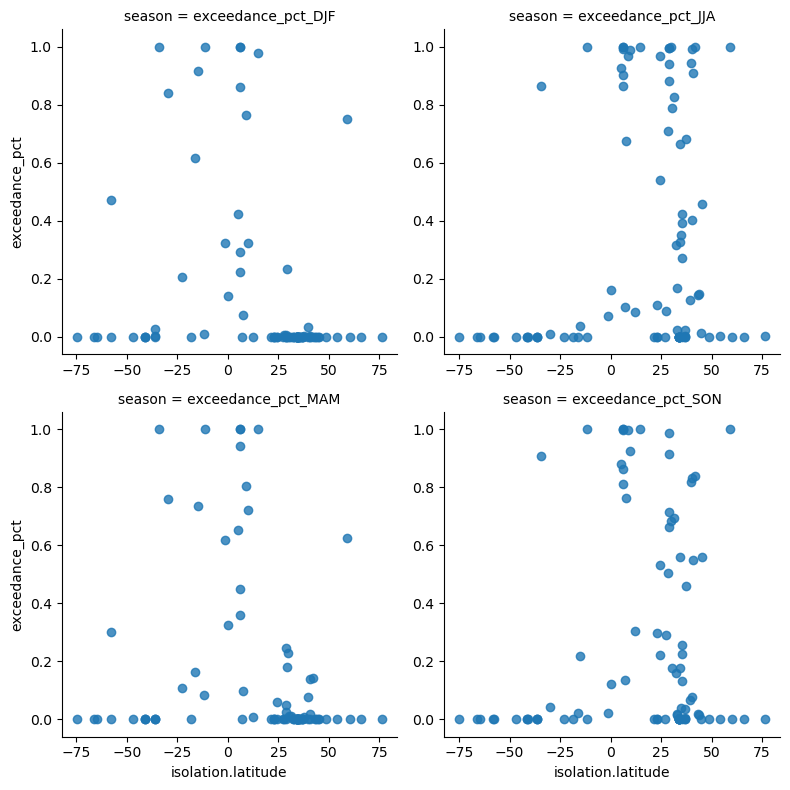

In [111]:
melted_plot = plankton.melt(
    id_vars='isolation.latitude', value_vars=['exceedance_pct_DJF', "exceedance_pct_JJA", "exceedance_pct_MAM", "exceedance_pct_SON"]
).rename(
    {"value" : "exceedance_pct", "variable" : 'season'}, axis=1)
sns.lmplot(x = 'isolation.latitude', y='exceedance_pct', col='season', col_wrap=2, height=4,data=melted_plot, fit_reg=False, sharex=False, sharey=False)